# Starbucks Capstone Challenge

## Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and that is the challenge to solve with this data set.

## Project Motivation
The purpose of this project is to determine which demographic groups respond best to which offer types, to help Starbucks make better decisions on sending out offers to targeted customers to increase sales and potentially save money. By predicting whether a customer will respond to an offer, Starbucks can make smarter decisions on whether or not to send an offer.

By sending offers to the RIGHT customers:
- Starbucks can boost brand recognition, customer loyalty, increase sales activities, promote a new product, etc.

By NOT sending offers to the RIGHT customers:
- Starbucks can save costs on the promotion event on customers **who would make purchases without offers**
- Starbucks can prevent customers to react negatively to an offer by not sending the offer

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, r2_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-dark')

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**offers (portfolio.json)**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**customers (profile.json)**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**events (transcript.json)**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [7]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


## Define Customer Response
**A user can receive an offer, never actually view the offer, and still complete the offer.**  
**As a result, we want to segment all customers into 3 groups:**
- **responded**
    - customers who were influenced by the offer and made a purchase - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- **not_responded**
    - customers who were not influenced by the offer and didn't make a purchase - those who **RECEIVED, VIEWED, AND NOT COMPLETED THE OFFER**
- **invalid_responded**
    - customers who were not influenced by the offer but did make a purchase - those who **RECEIVED, NOT VIEWED, BUT COMPLETED THE OFFER**

### Exclude informational offers
- The objective of the project is to predict customer response to offers, informational offers do not lead to any response
- Exclude them to only analyze discount and bogo offers
- Seperate transaction events and offer events, to define customer response based on offer events

In [8]:
# Add offer info into events dataset
events = pd.merge(events, offers[['id','offer']], how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)
events.offer.unique()

array(['bogo_5_7_5', 'discount_20_10_5', 'discount_10_7_2',
       'discount_10_10_2', 'bogo_10_5_10', 'bogo_5_5_5', 'discount_7_7_3',
       'informational_0_4_0', 'bogo_10_7_10', 'informational_0_3_0', nan],
      dtype=object)

In [9]:
# Store offer types
informational_offers = ['informational_0_3_0','informational_0_4_0']
discount_offers = ['discount_20_10_5','discount_10_7_2','discount_10_10_2','discount_7_7_3']
bogo_offers = ['bogo_5_7_5','bogo_10_5_10','bogo_5_5_5','bogo_10_7_10']

# Remove informational events out of events data
informational_events = events[events.offer.isin(informational_offers)]
offer_events = events[~events.offer.isin(informational_offers)]

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']
transaction_events = events[events.event == 'transaction']

### Create customer_funnels dataset to segment customer groups

In [10]:
# Create customer_funnels dataset
customer_funnels = offer_events.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
00b3400e4ff64ee68ce9ada1d0c222f0,3.0,3.0,1.0
1c518fa4dd634c508d76786db0533600,3.0,4.0,2.0
912cd8d71f864bc8927ca1ff4a7a800f,2.0,2.0,2.0
8a106b139eb84a1fbd81d66f002426cc,3.0,3.0,3.0
74429a966afd4d5baa2c31700c782e1b,2.0,3.0,2.0


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [11]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
dtype: float64

In [12]:
def create_3_demo_groups(funnel):
    '''
    create 3 datasets that describe customer funnels for 3 response types - responded/not_responded/invalid_responded

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        responded, not_responded, invalid_responded - segmented datasets from the original funnel data
    '''

    # Create 3 response type groups
    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% customers responded to offers')
    print(round(len(not_responded)/len(funnel)*100,2), '% customers did not respond to any offer')
    print(round(len(invalid_responded)/len(funnel)*100,2), '% customers completed offers without viewing offer')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(invalid_responded) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, invalid_responded

### customer_funnels dataset represents customer response for all offers
So we know that for all offers:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

**Later on, the funnel input will be funnels for a specific offer, to analyze each offer individually**

In [13]:
responded, not_responded, invalid_responded = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [70]:
# Impute responses into customers data
customers['responded'] = customers.id.isin(responded.index).astype(int)
customers['not_responded'] = customers.id.isin(not_responded.index).astype(int)
customers['invalid_responded'] = customers.id.isin(invalid_responded.index).astype(int)
customers['response'] = customers[['responded','not_responded','invalid_responded']].idxmax(axis=1)
customers.head()

,gender,age,id,income,membership_days,responded,not_responded,invalid_responded,response
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,0,1,invalid_responded
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,0,responded
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,0,responded
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,0,responded
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,responded


# Demographic EDA for the 3 response types

In [14]:
# Null values in customers data
customers.isnull().mean()

gender             0.127928
age                0.127928
id                 0.000000
income             0.127928
membership_days    0.000000
dtype: float64

In [15]:
# Some customers didn't provide any information regarding age, gender and income
# Remove them from customers dataset and create null_customers to store them
null_customers = customers[customers.isnull().any(axis=1)]
customers = customers.dropna()

In [17]:
def plot_compare_3_groups(funnel):

    '''
    plot age/income/membership_days distributions by the 3 response groups

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        None - plot 3 distributions
    '''

    # Define response groups
    responded, not_responded, invalid_responded = create_3_demo_groups(funnel)

    # Plot 3 graphs
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(customers[customers.id.isin(responded.index)].age, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].age, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].age, label='invalid responded');
    plt.legend();
    plt.subplot(1,3,2)
    sns.distplot(customers[customers.id.isin(responded.index)].income, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].income, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].income, label='invalid responded');
    plt.legend();
    plt.subplot(1,3,3)
    sns.distplot(customers[customers.id.isin(responded.index)].membership_days, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].membership_days, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].membership_days, label='invalid responded');
    plt.legend();
    plt.tight_layout()

### EDA insights for all offers in general
- In general, 74.4% customers responded to offers, and 1.06% customers invalidly responded to offers
- **not responded customers (orange bars)** are mostly young in age, have low income, and have a short length of membership
- **responded customers (blue bars)** are average in age, average in income, and average in length of membership
- **invalid responded customers (green bars)** are the highest in age, the highest in income, highest in length of membership

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


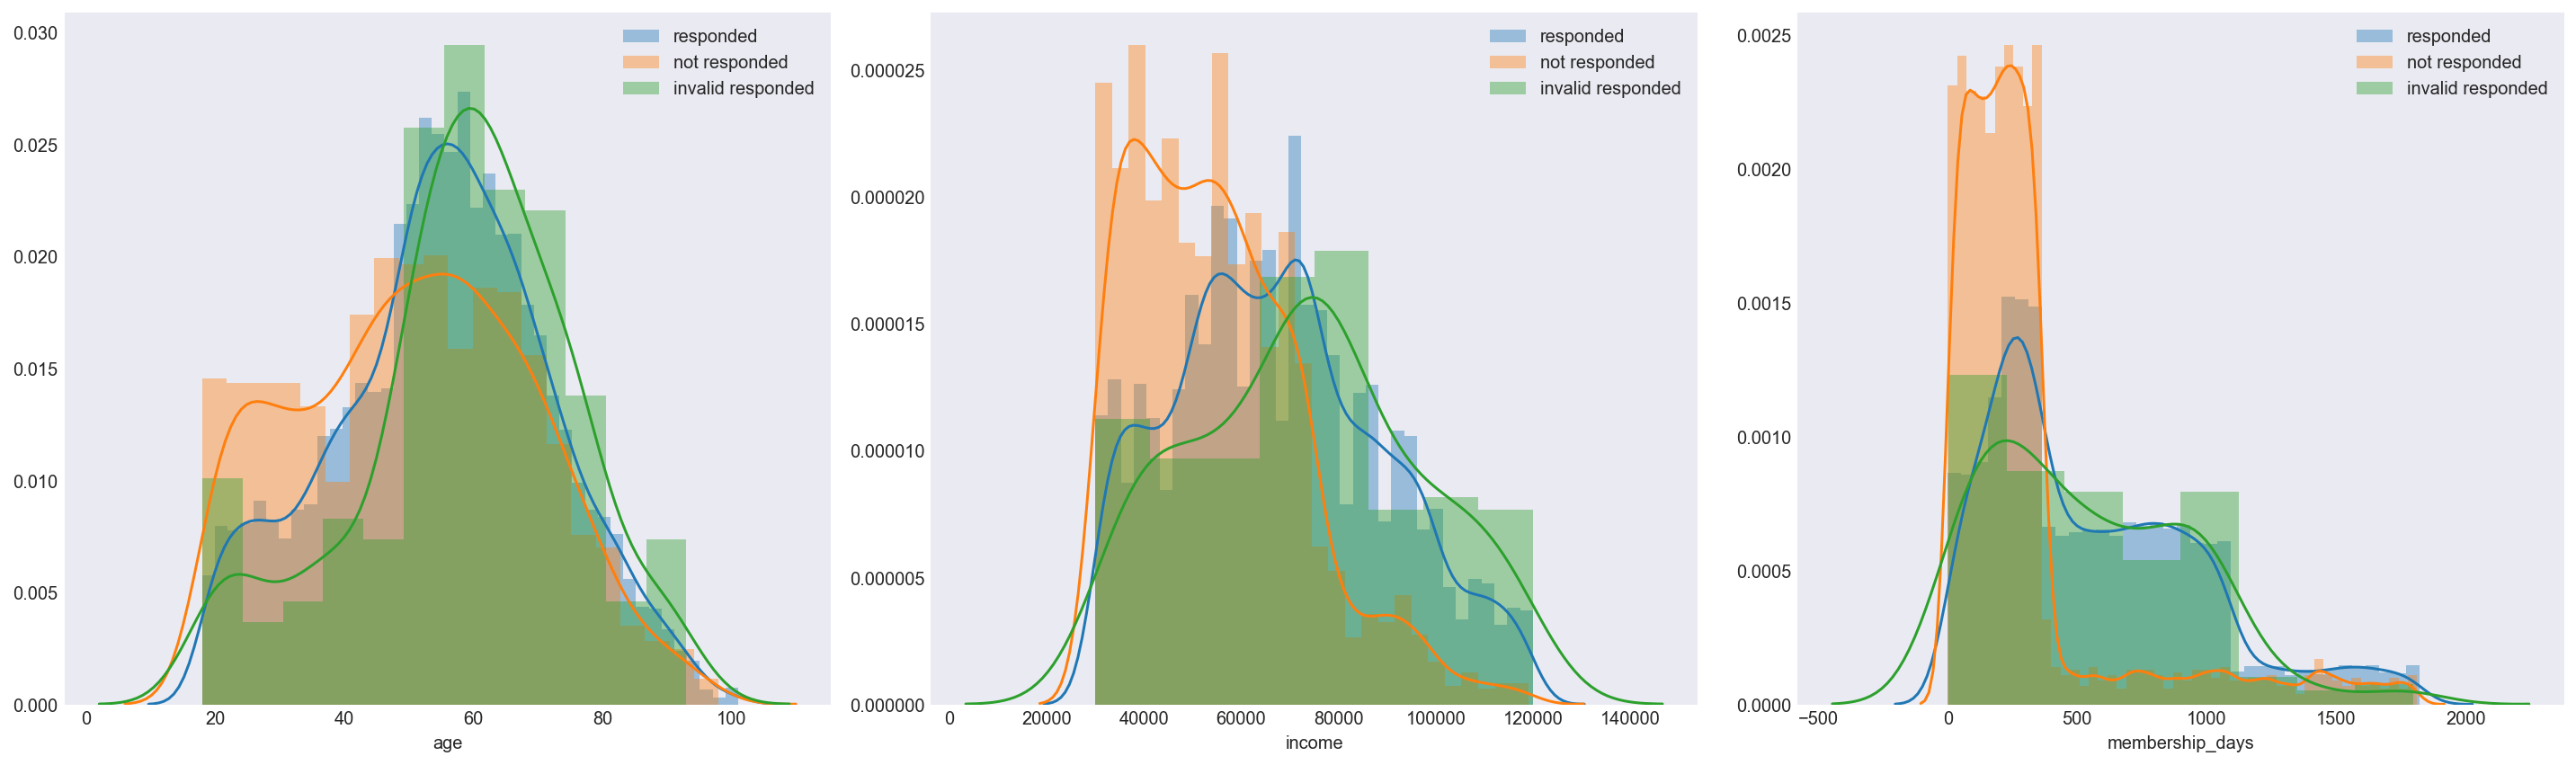

In [71]:
plot_compare_3_groups(customer_funnels)

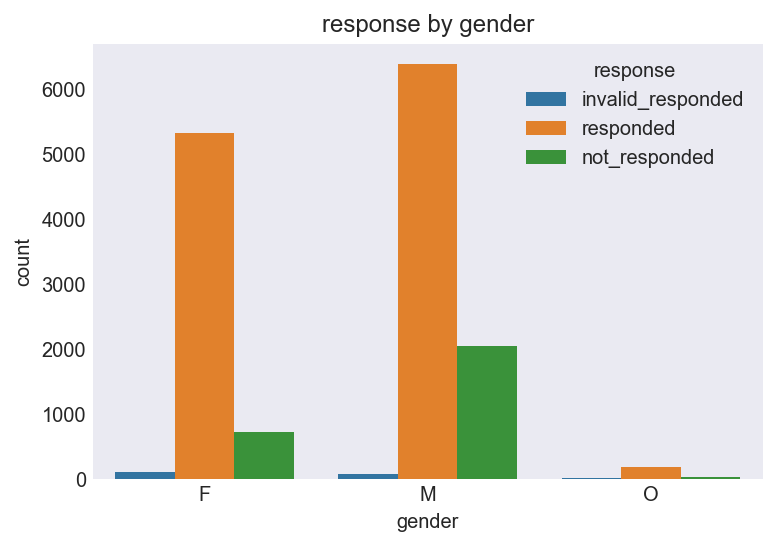

In [69]:
sns.countplot(data=customers, x='gender', hue='response');
plt.title('response by gender');

### Dig deeper into response groups by each offer type
Above is a general customer response analysis for all offer types. Below, we will examine distributions by each offer type to analyze trends in the demographics.

In [72]:
def create_offer_funnels(offer):

    '''
    create a funnel dataset by 8 different offer types - discount offers and bogo offers

    INPUT:
        offer - the specific offer type (discount_7_7_3)
    OUTPUT:
        funnel - customer funnel dataset of this given offer
    '''

    #
    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]
    # funnel['completion_rate'] = funnel.offer_completed / funnel.offer_received

    return funnel

In [73]:
create_offer_funnels('discount_7_7_3').sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
b1dbb320a2484f40824363fd4be52e1f,1.0,2.0,2.0
2b154713de07457db1e61bbf5b904d5e,1.0,1.0,1.0
2ff22c34acd448d583f05fa2461358a2,NaN,1.0,1.0
855ab85b5bac4be0a9c9aff8cf9d83e2,NaN,1.0,1.0
7d170c59cd1e466982fc5a4dd852b3a7,NaN,1.0,1.0


### EDA for discount offers
- Note that the offers are broken down into **min_spend, expire_days, and reward**
- For example, discount_20_10_5 means a discount offer with 20 dollars minumum spend, expires in 10 days, and 5 dollars reward

### Insights:
- The discount offer people love the most is discount_10_10_2, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5, with 23.09 response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)

In [73]:
# Exammine discount offer types
discount_offers

['discount_20_10_5', 'discount_10_7_2', 'discount_10_10_2', 'discount_7_7_3']

23.09 % customers responded to offers
53.28 % customers did not respond to any offer
23.63 % customers completed offers without viewing offer


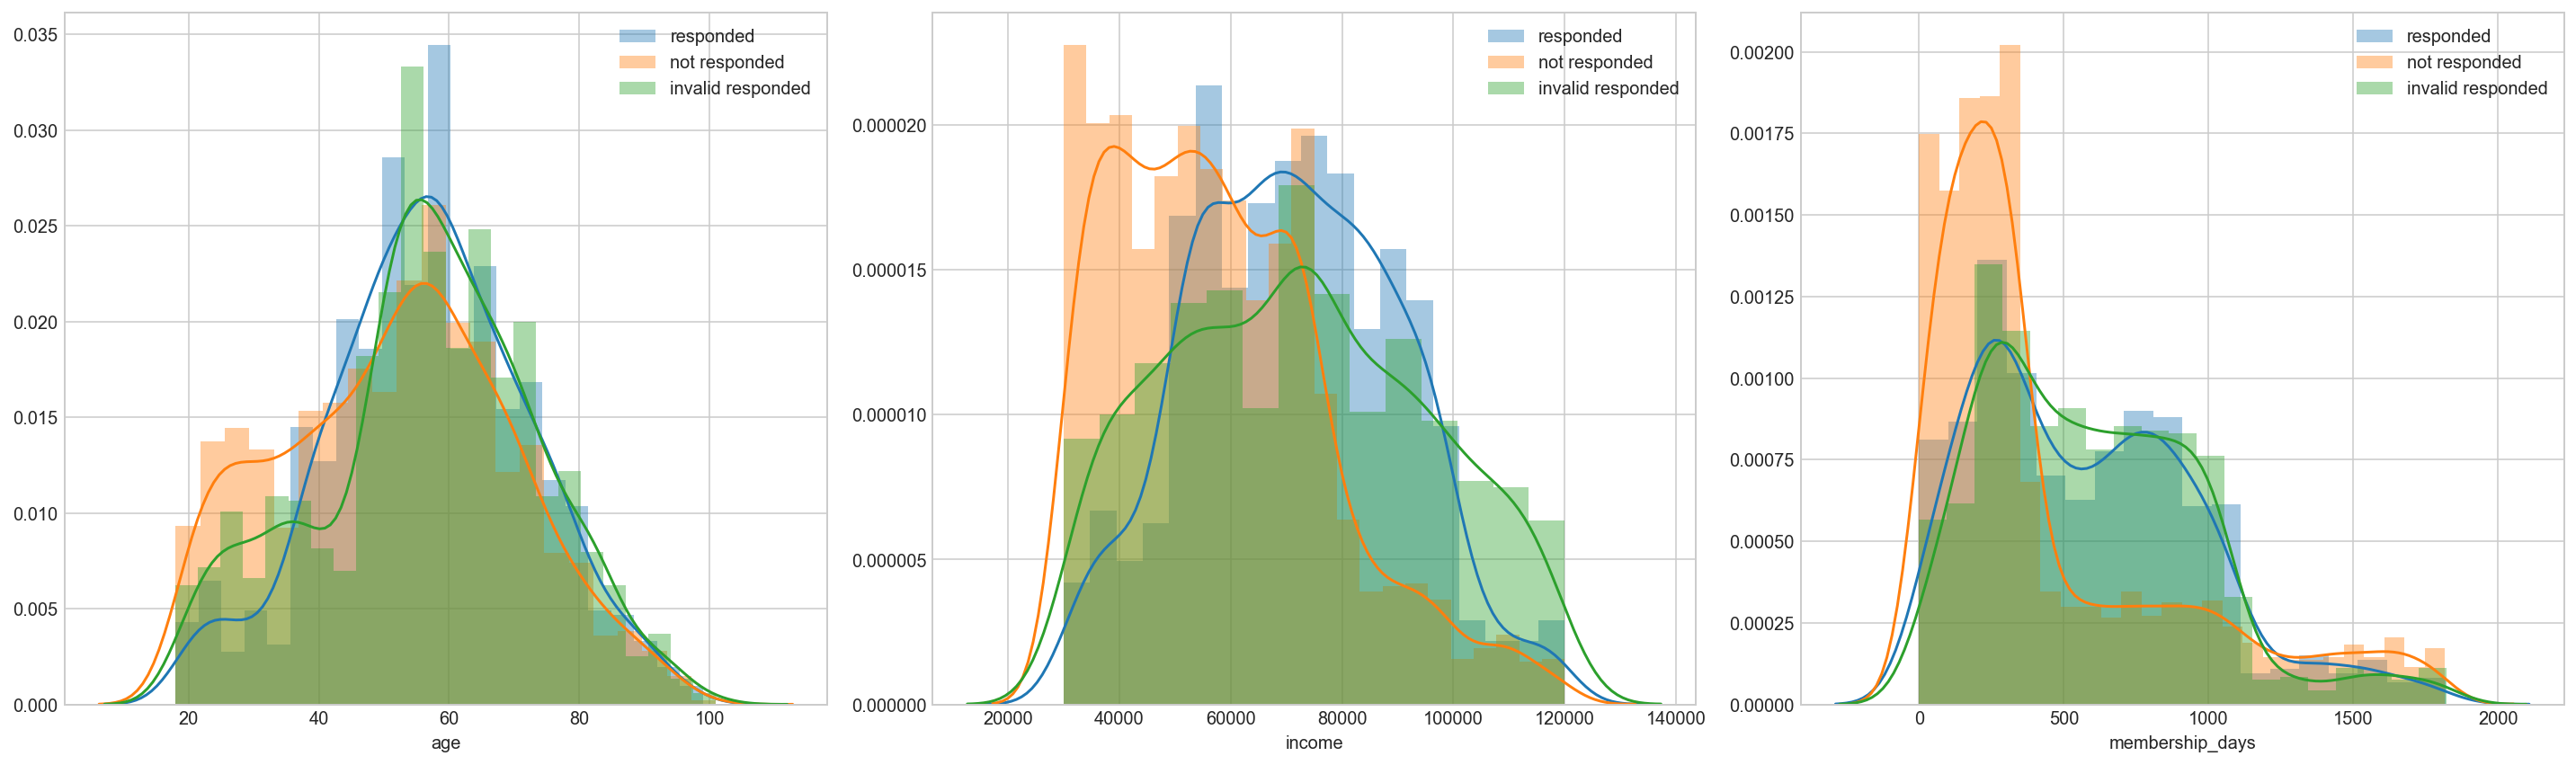

In [74]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5'))

38.42 % customers responded to offers
44.63 % customers did not respond to any offer
16.95 % customers completed offers without viewing offer


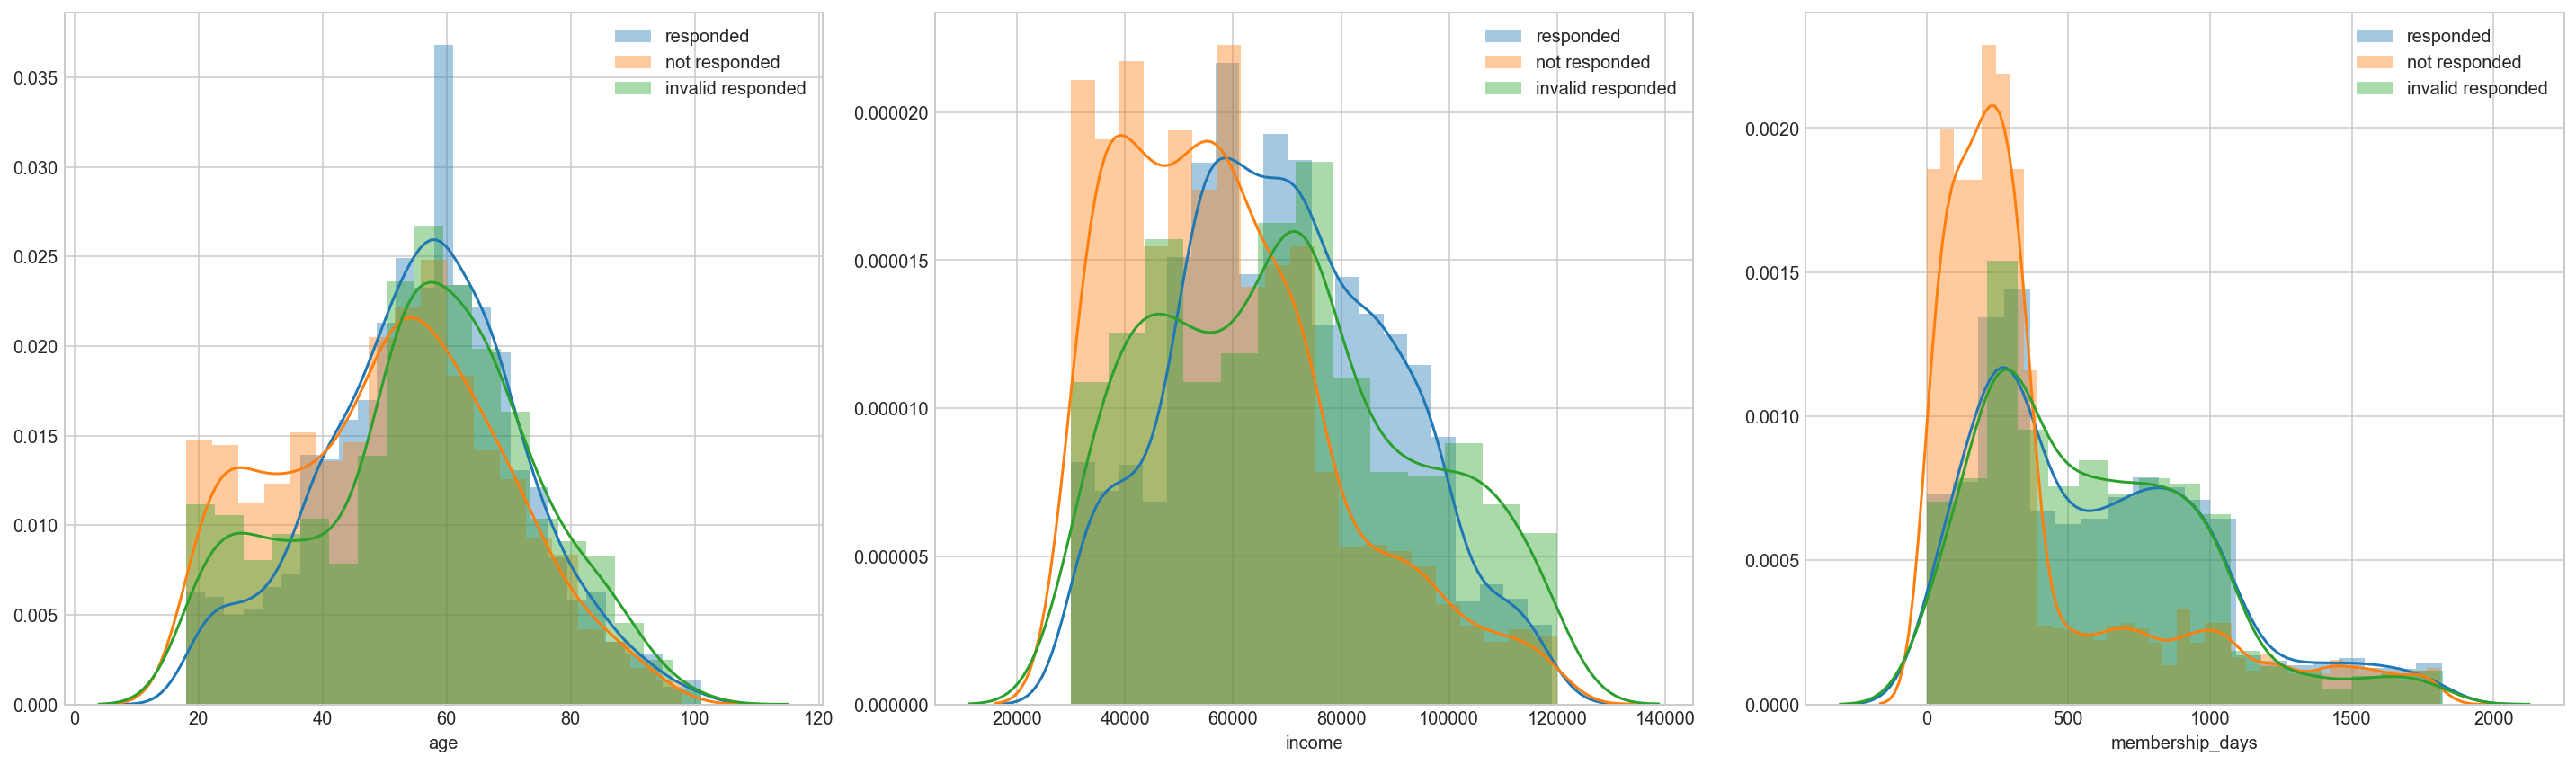

In [75]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2'))

70.01 % customers responded to offers
28.46 % customers did not respond to any offer
1.53 % customers completed offers without viewing offer


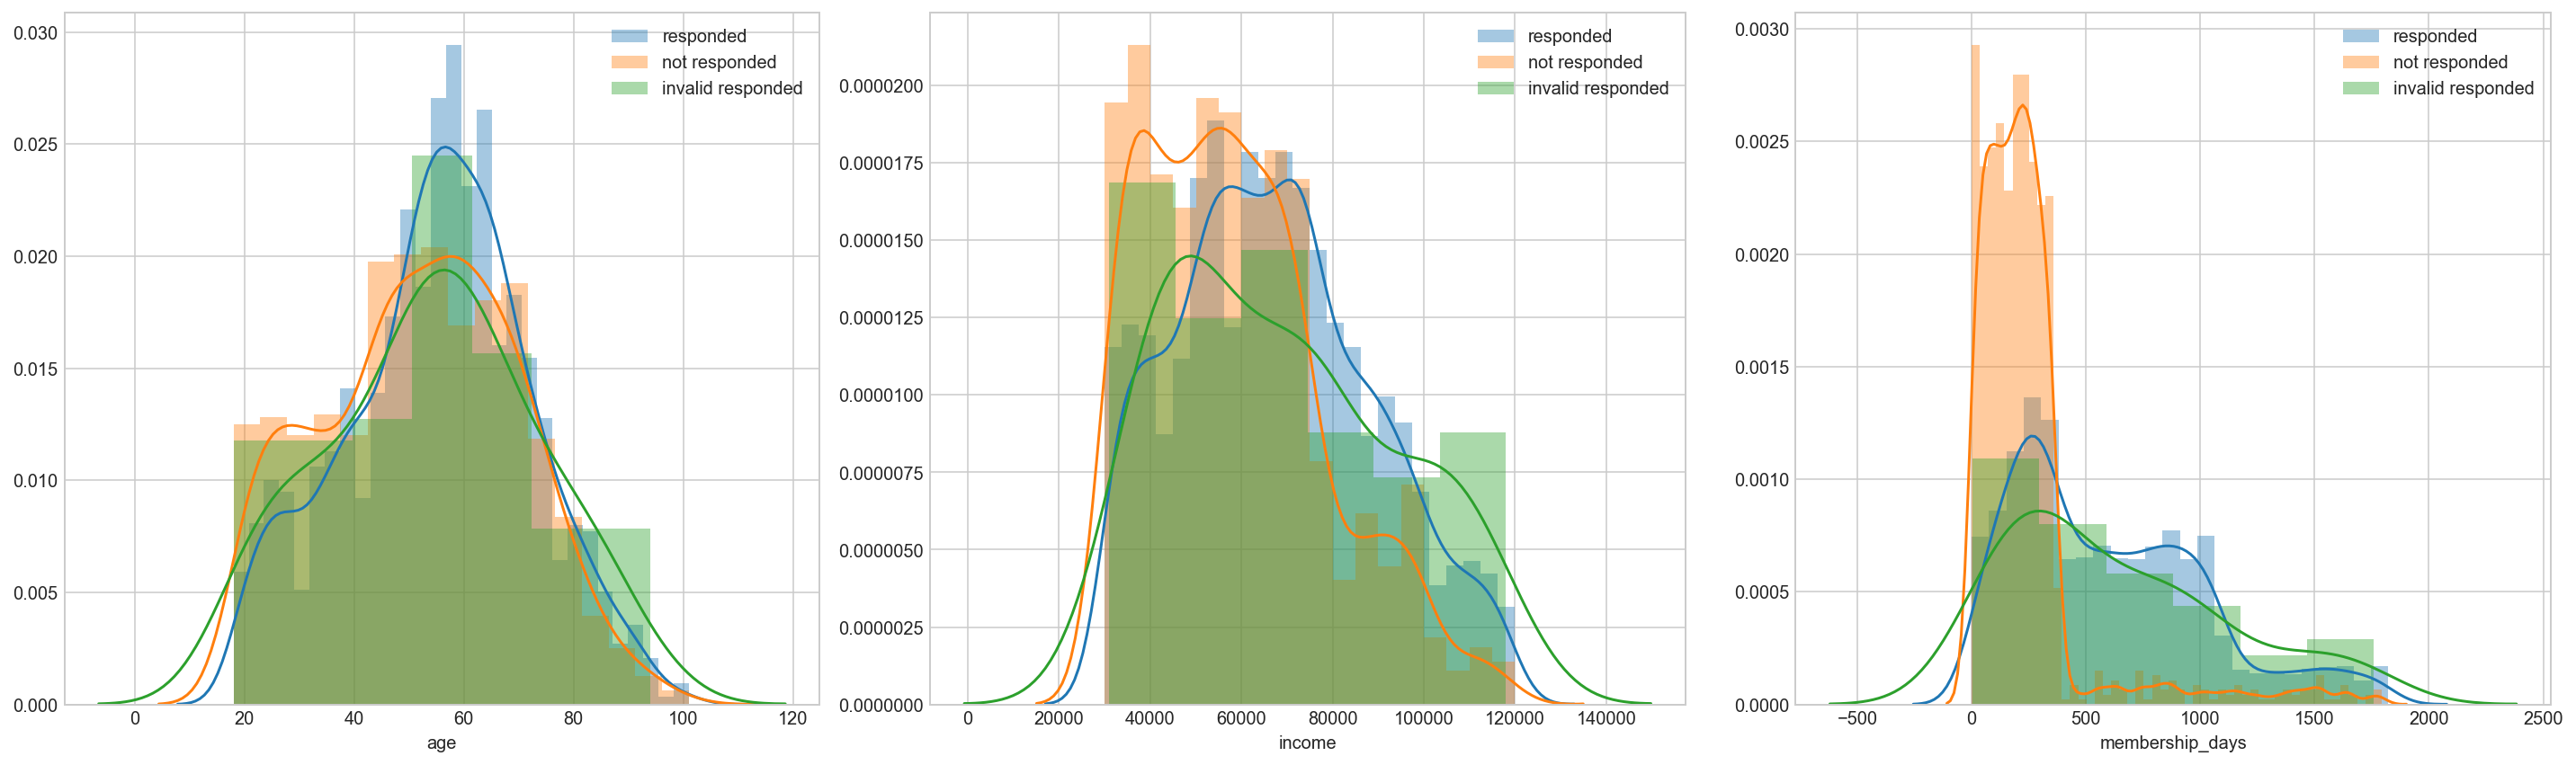

In [18]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2'))

68.19 % customers responded to offers
30.1 % customers did not respond to any offer
1.71 % customers completed offers without viewing offer


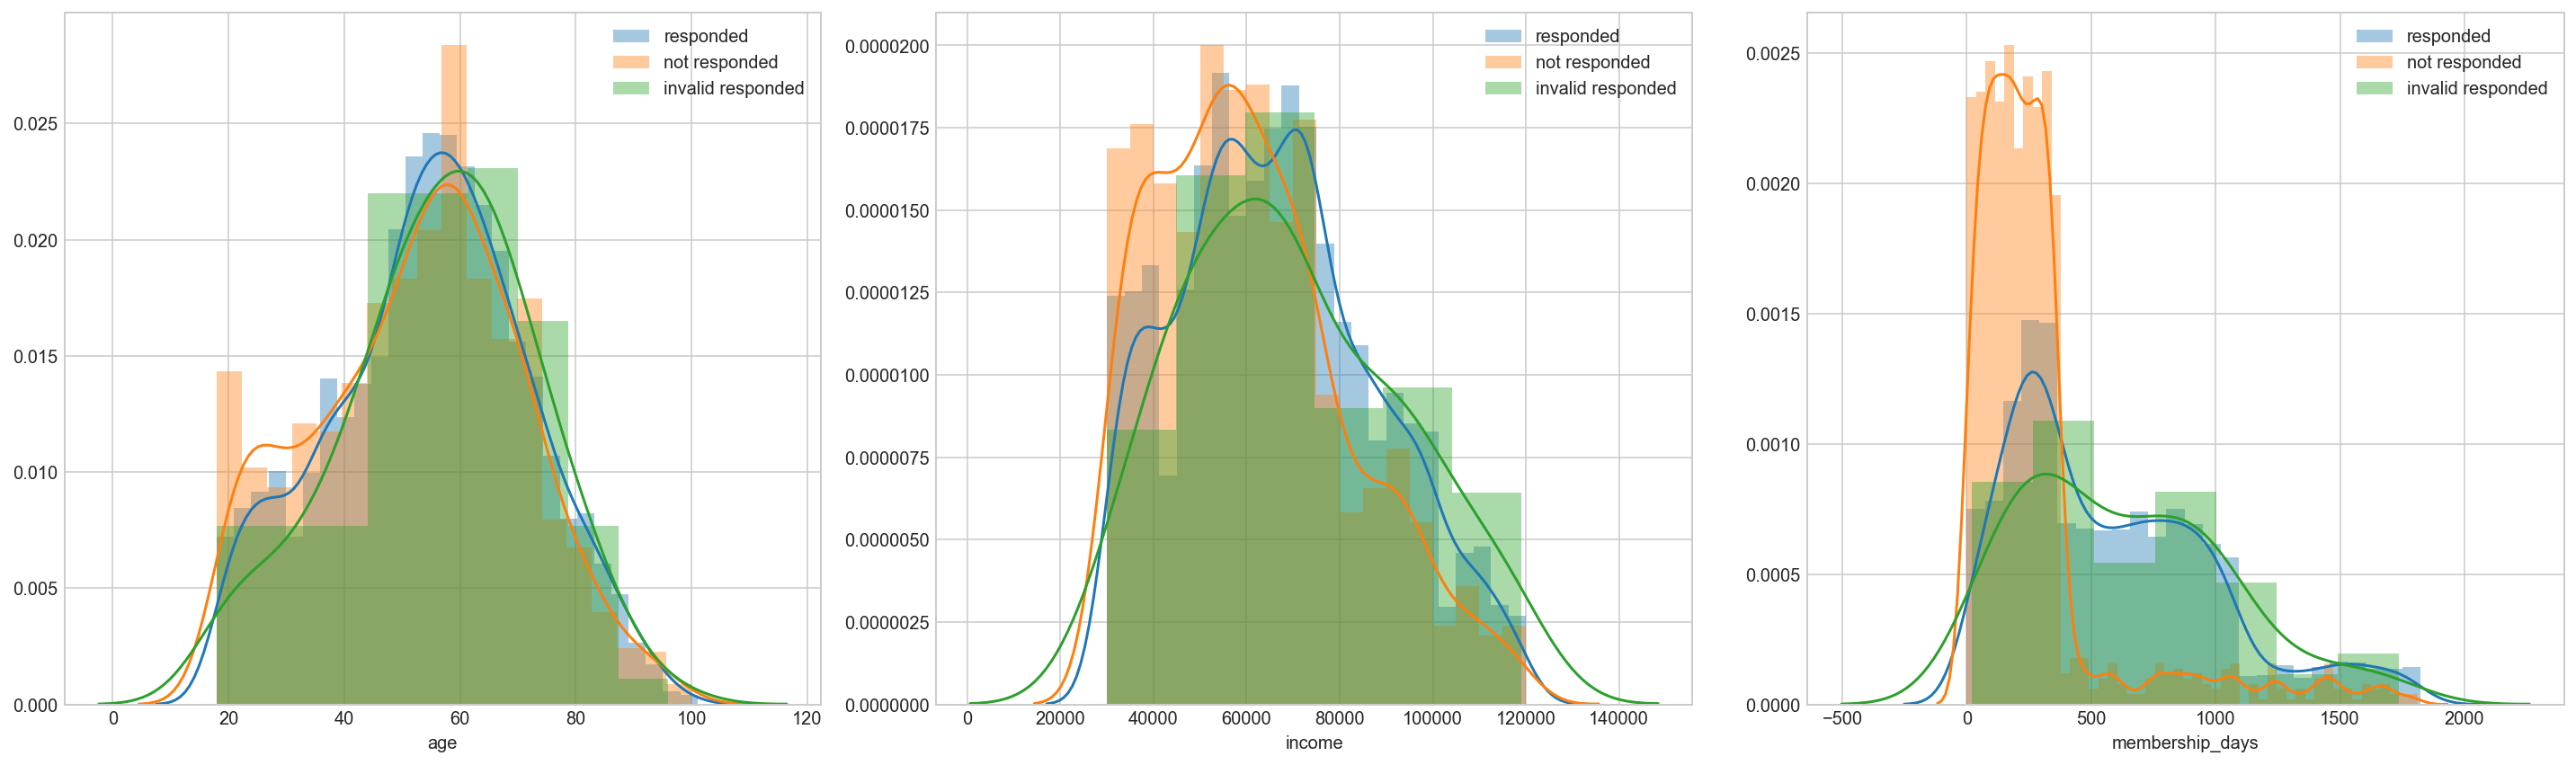

In [19]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3'))

### EDA for BOGO offers
- The BOGO offer that people love the most is bogo_5_5_5, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5, with a 39.4% response rate

In [76]:
bogo_offers

['bogo_5_7_5', 'bogo_10_5_10', 'bogo_5_5_5', 'bogo_10_7_10']

39.4 % customers responded to offers
40.46 % customers did not respond to any offer
20.14 % customers completed offers without viewing offer


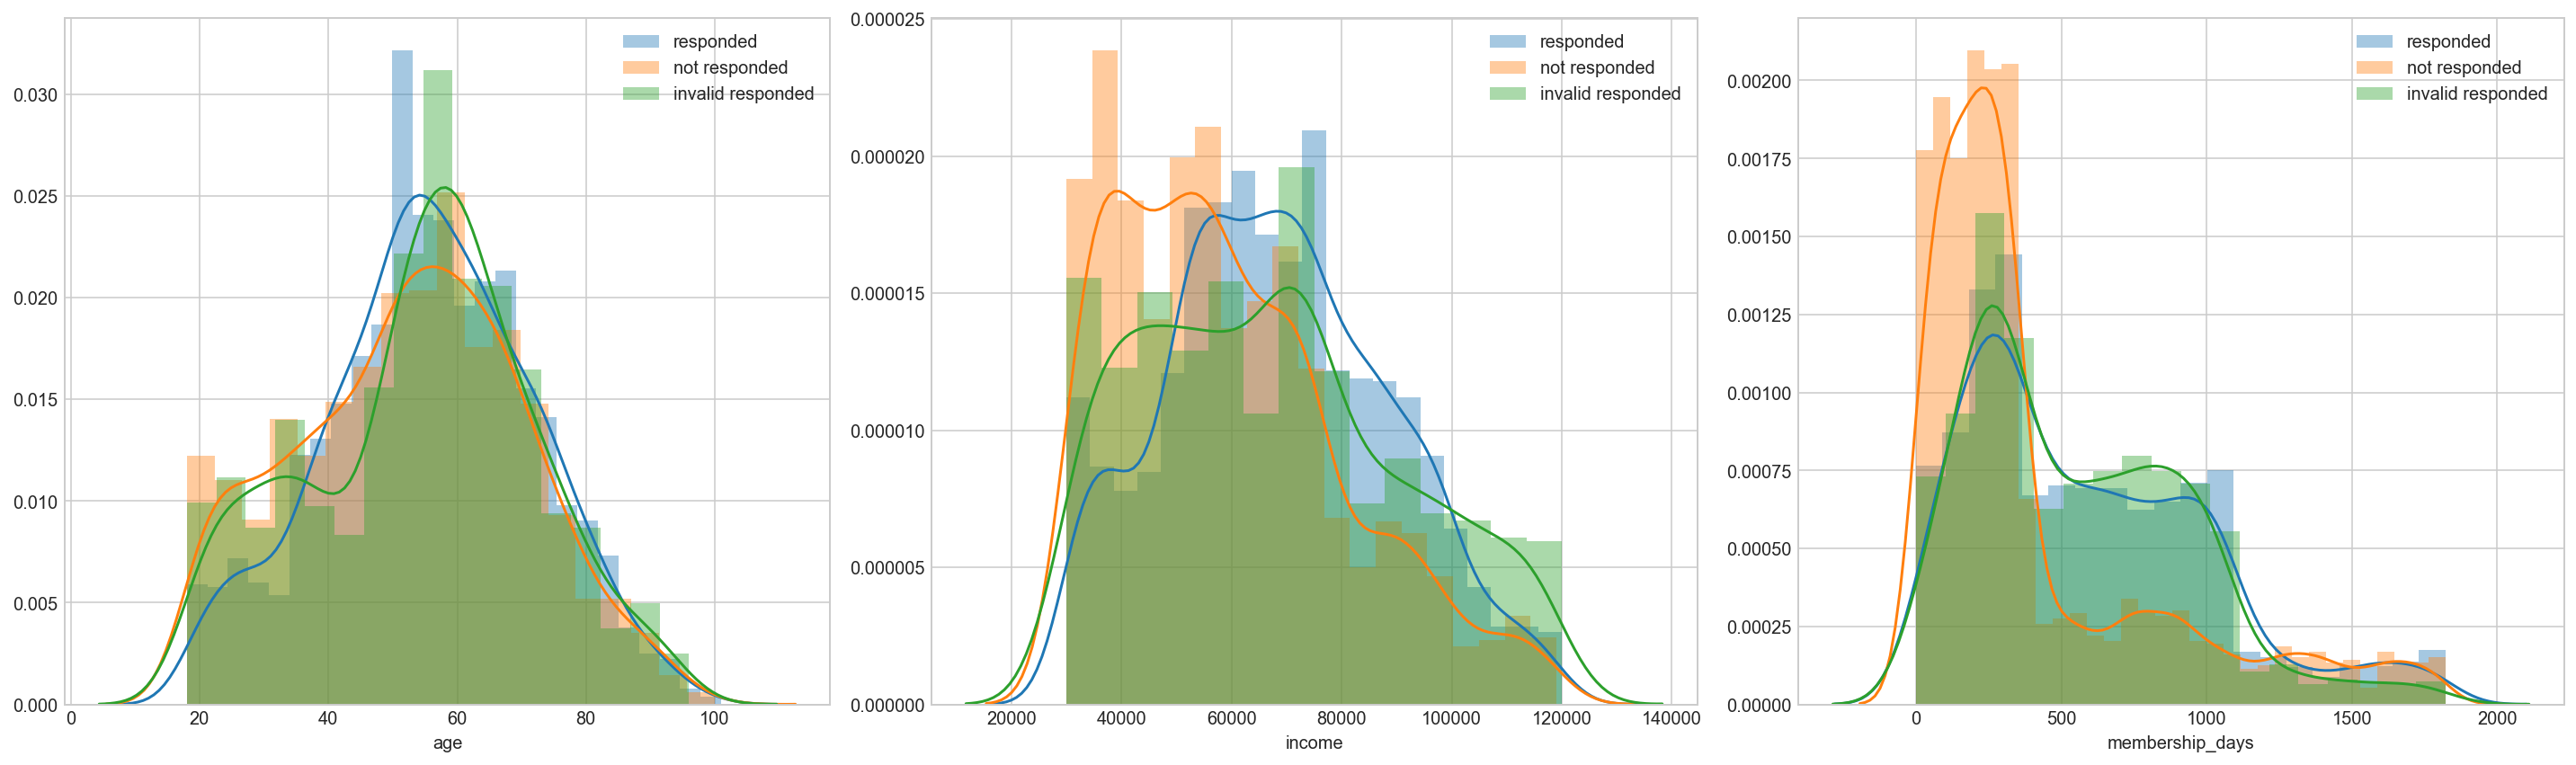

In [77]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5'))

44.63 % customers responded to offers
54.42 % customers did not respond to any offer
0.95 % customers completed offers without viewing offer


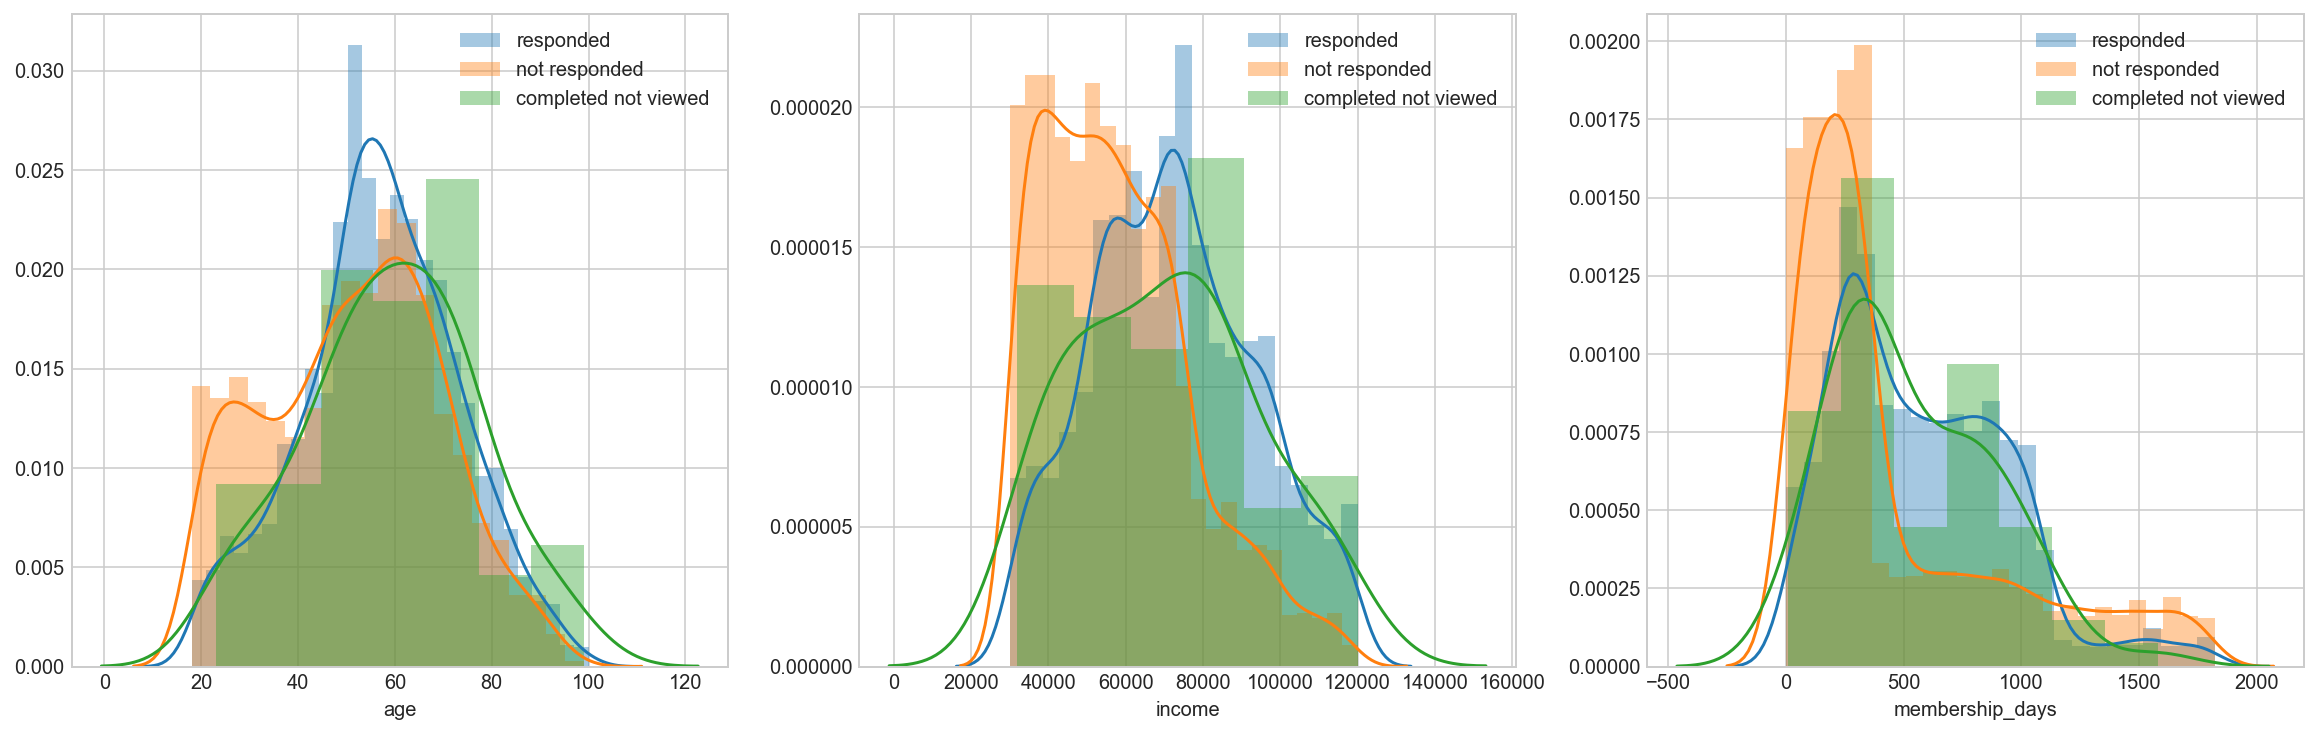

In [29]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10'))

58.37 % customers responded to offers
40.26 % customers did not respond to any offer
1.37 % customers completed offers without viewing offer


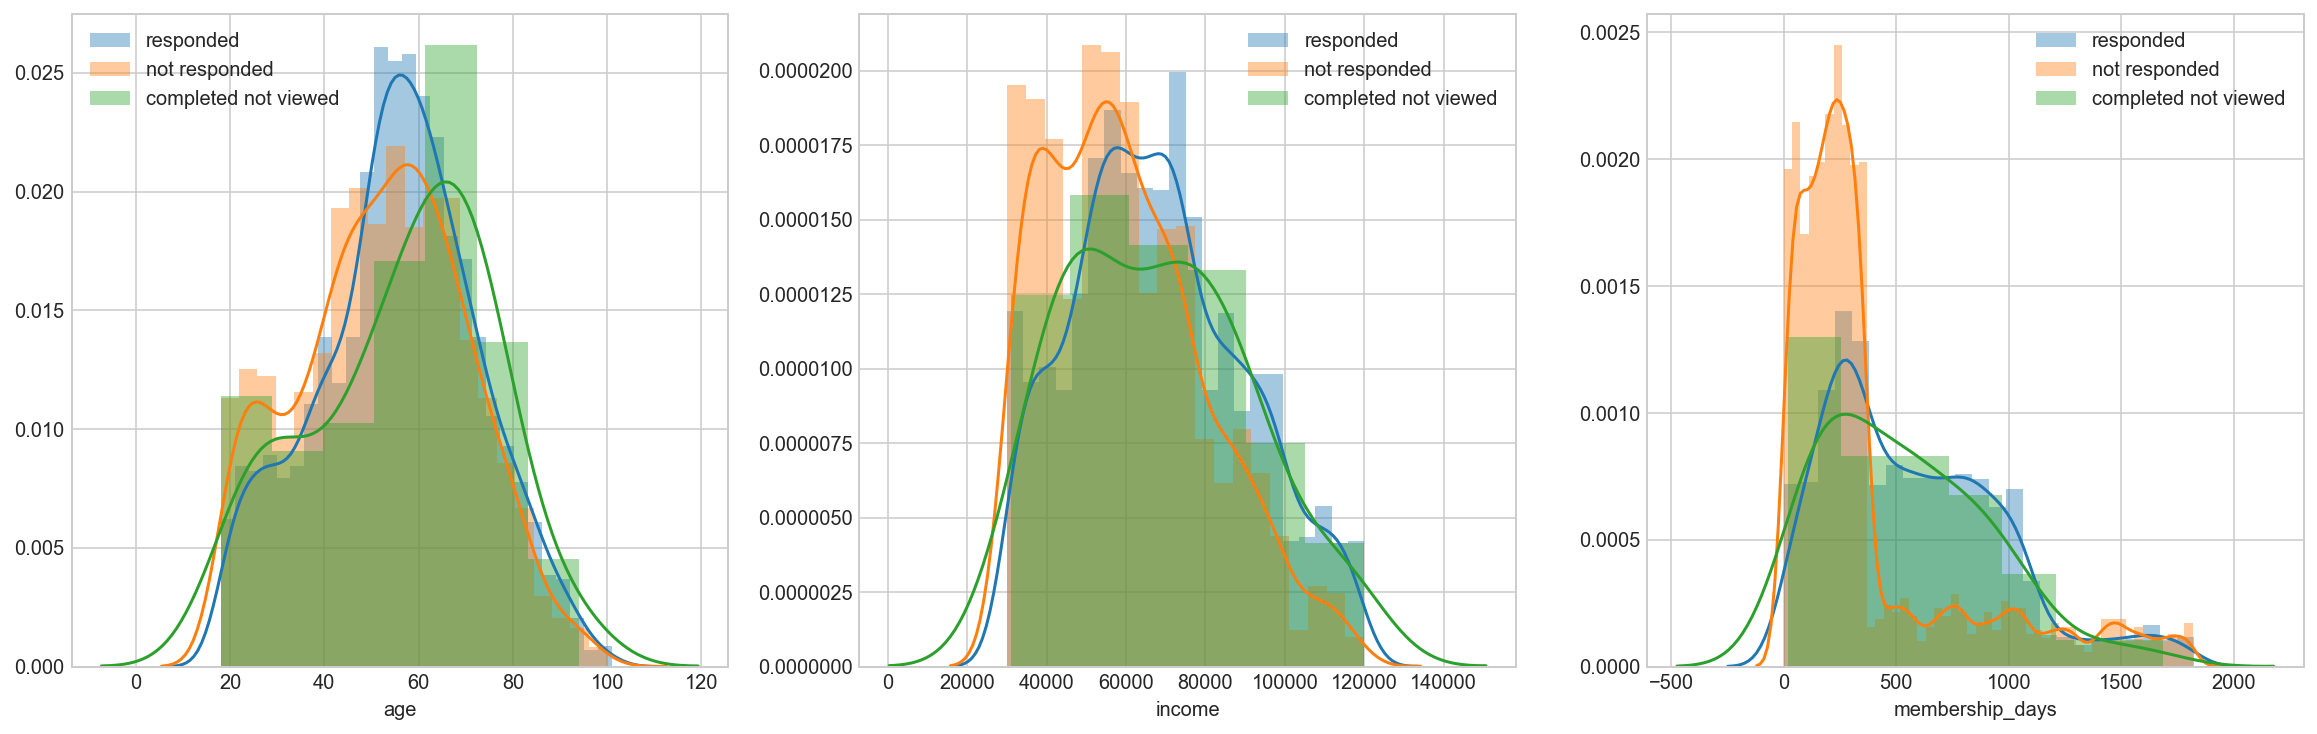

In [30]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5'))

44.6 % customers responded to offers
50.16 % customers did not respond to any offer
5.24 % customers completed offers without viewing offer


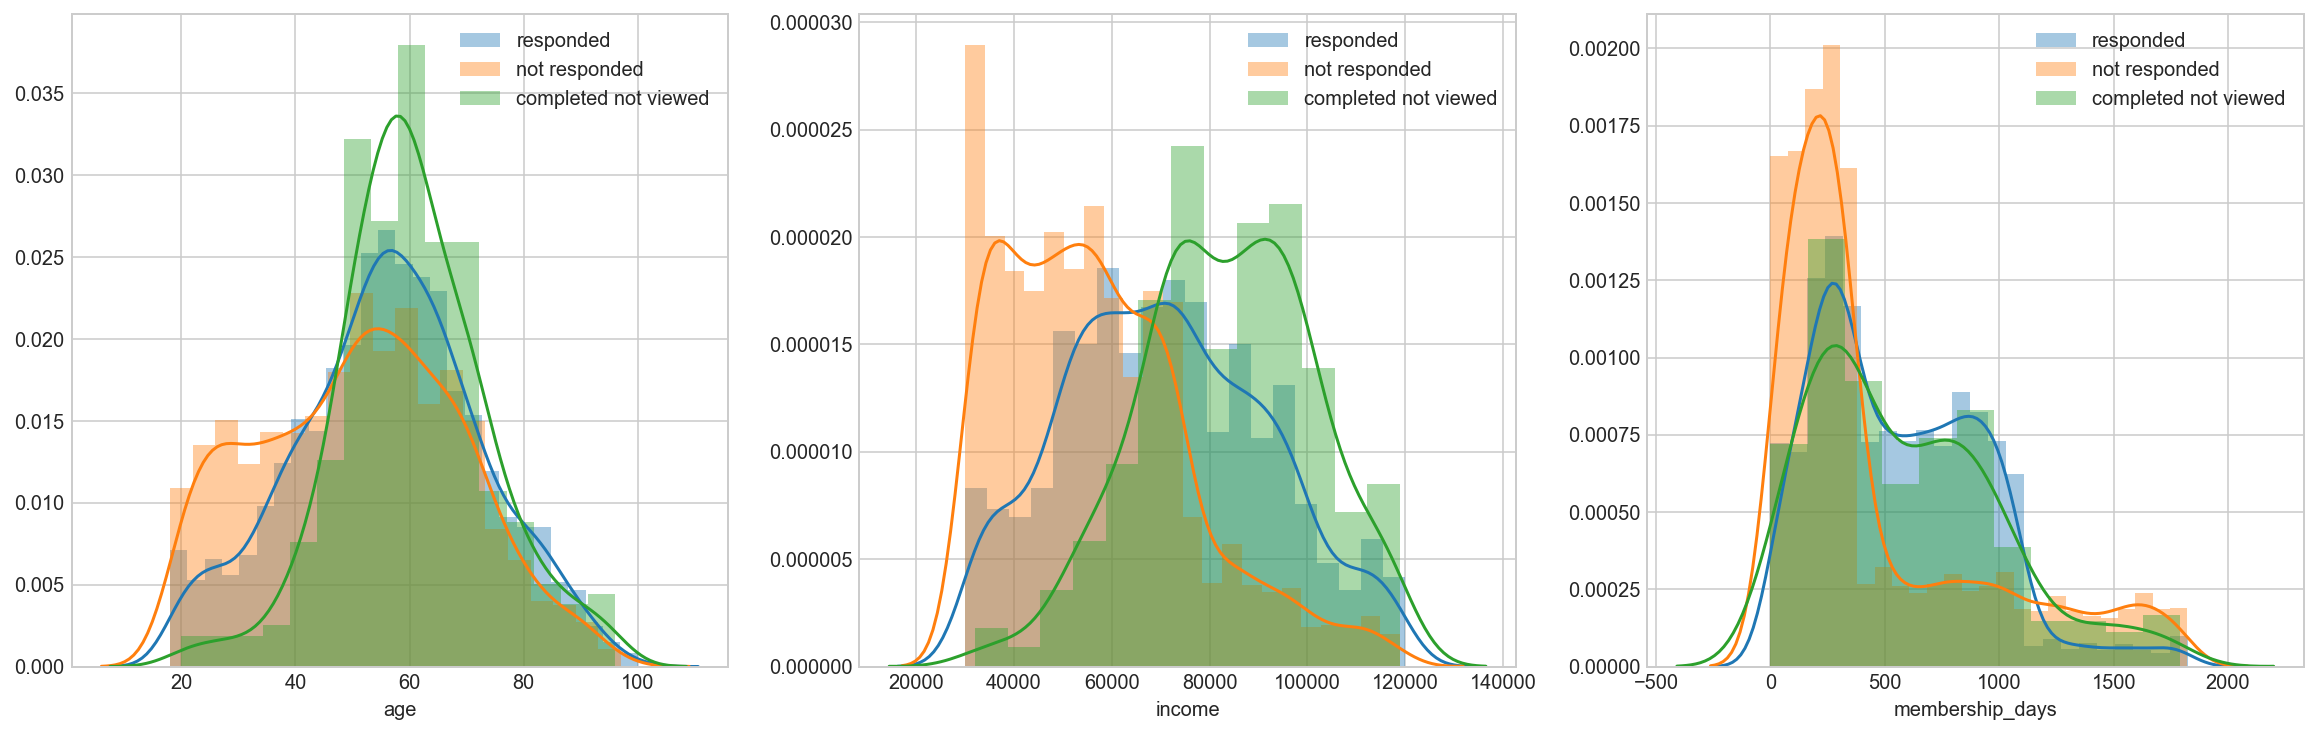

In [31]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10'))

### Impute features into the customers dataset
- response - whether the customer responded to any offers
- invalid_response - whether the customer had invalid responses to any offers (completed not viewed)
- response and invalid response for all 8 offer types


In [80]:
def get_responded_ids(offer):
    '''
    INPUT:
        offer - the specific offer type
    OUTPUT:
        responded - a list of responded customer ids who responded to the given offer
    '''
    funnel = create_offer_funnels(offer)
    responded = funnel.dropna().index

    return responded

In [81]:
# Impute valid responses for all 8 offer types
for offer in bogo_offers + discount_offers:
    customers[offer] = customers.id.isin(get_responded_ids(offer)).astype(int)

customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,bogo_10_7_10,discount_20_10_5,discount_10_7_2,discount_10_10_2,discount_7_7_3
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,0,0,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,1,0,0,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,0,0,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,0,0,1,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,0,0,0,1,0


In [82]:
def invalid_responded_ids(offer):
    '''
    INPUT:
        offer - the specific offer type
    OUTPUT:
        invalid_responded - a list of customer ids for invalidly responded to the given offer
    '''
    funnel = create_offer_funnels(offer)
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()].index

    return invalid_responded

In [83]:
# Impute invalid responses for all 8 offer types
for offer in bogo_offers + discount_offers:
    customers['invalid_'+offer] = customers.id.isin(invalid_responded_ids(offer)).astype(int)

customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,discount_10_10_2,discount_7_7_3,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Impute transactions and amount spent per week per customer
The reason why I chose weekly average as the metric is due to the nature of the test. This test is conducted for a month, while certain customers received their first offers from the first day, while some customers received their first offer at the end of the month. 

In [84]:
transaction_events.head()

,customer_id,event,hour,amount_spent,reward_received,offer
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN,NaN


### Create a groupby result for average weekly transaction per customer

In [85]:
# Create new feature - week
transaction_events['week'] = (transaction_events.hour / 24 / 7).astype(int)

# group by transaction events by customer id and week
transactions = transaction_events.groupby(['customer_id','week']).event.count().to_frame().reset_index()
transactions.rename({'event':'avg_weekly_transactions'},axis=1,inplace=True)

# group by transaction counts by customer
transactions = transactions.groupby('customer_id').avg_weekly_transactions.mean().to_frame().reset_index()
transactions.head()

,customer_id,avg_weekly_transactions
0,0009655768c64bdeb2e877511632db8f,2.000000
1,00116118485d4dfda04fdbaba9a87b5c,1.500000
2,0011e0d4e6b944f998e987f904e8c1e5,1.666667
3,0020c2b971eb4e9188eac86d93036a77,2.666667
4,0020ccbbb6d84e358d3414a3ff76cffd,2.400000


In [86]:
# left join average transactions to customers data
customers = pd.merge(customers, transactions, how='left', left_on='id', right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,discount_7_7_3,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3,avg_weekly_transactions
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1.500000
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1.750000
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.500000
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1.000000
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.333333


### Create a groupby result for average weekly amount spent per customer

In [87]:
# group by amount_spent by customer_id and week, and by customer
amount_spent = transaction_events.groupby(['customer_id','week']).amount_spent.mean().to_frame().reset_index()
amount_spent = amount_spent.groupby('customer_id').amount_spent.mean().to_frame().reset_index()
amount_spent.rename({'amount_spent':'avg_weekly_amount_spent'},axis=1,inplace=True)
amount_spent.head()

,customer_id,avg_weekly_amount_spent
0,0009655768c64bdeb2e877511632db8f,16.647500
1,00116118485d4dfda04fdbaba9a87b5c,1.197500
2,0011e0d4e6b944f998e987f904e8c1e5,14.477778
3,0020c2b971eb4e9188eac86d93036a77,24.615833
4,0020ccbbb6d84e358d3414a3ff76cffd,12.077500


In [88]:
# Merge average weekly amount spent to customers dataset
customers = pd.merge(customers, amount_spent, how='left',left_on='id',right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.fillna(0,inplace=True)
customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3,avg_weekly_transactions,avg_weekly_amount_spent
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1.500000,25.057500
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1.750000,22.900000
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1.500000,19.037500
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1.000000,12.143333
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.333333,3.135000


### K-Means Clustering to segment customers

In [90]:
# Scaled customers data for clustering
scaler = StandardScaler()
scaled_customers = customers.copy()
scaled_customers.set_index('id',inplace=True)
scaled_customers = pd.get_dummies(scaled_customers)
scaled_customers = scaler.fit_transform(scaled_customers)

In [105]:
# Cluster the page level data for further insights
kmeans = KMeans(n_clusters=3, random_state=42)
customers['cluster'] = kmeans.fit_predict(scaled_customers)
customers['cluster'] = customers.cluster + 1

In [106]:
customers.cluster.value_counts()

2    6332
1    5491
3    2997
Name: cluster, dtype: int64

In [107]:
def compare_cluster_distributions(feature):
    '''
    INPUT:
        feature - a continuous variable from customers data (income, age, membership_days)
    OUTPUT:
        None - distribution plot for the given feature by cluster
    '''
    for cluster in customers.cluster.unique():
        sns.distplot(customers[customers.cluster == cluster][feature], label=cluster)
        plt.legend()

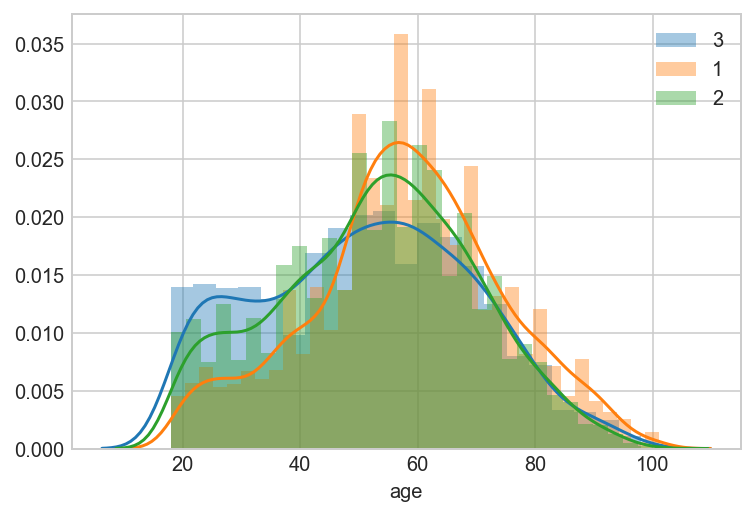

In [118]:
compare_cluster_distributions('age')

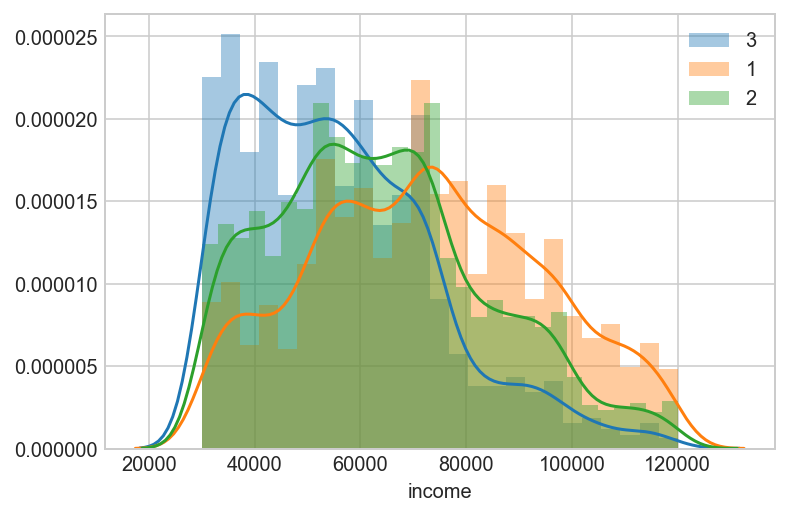

In [108]:
compare_cluster_distributions('income')

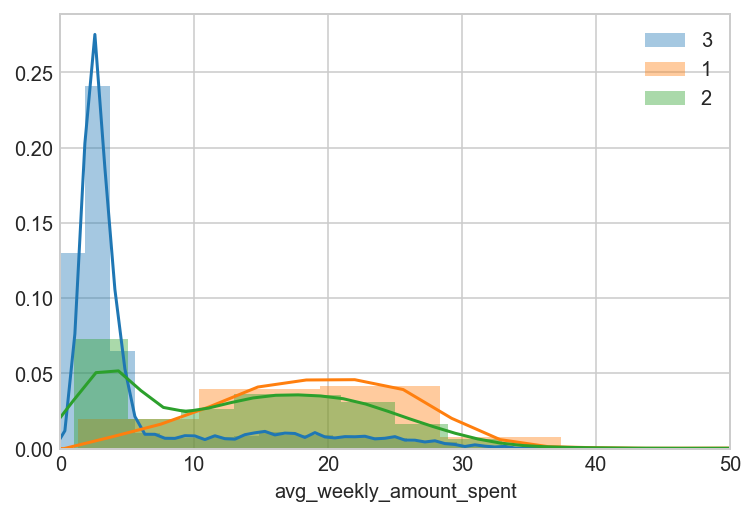

In [109]:
compare_cluster_distributions('avg_weekly_amount_spent')
plt.xlim(0,50);

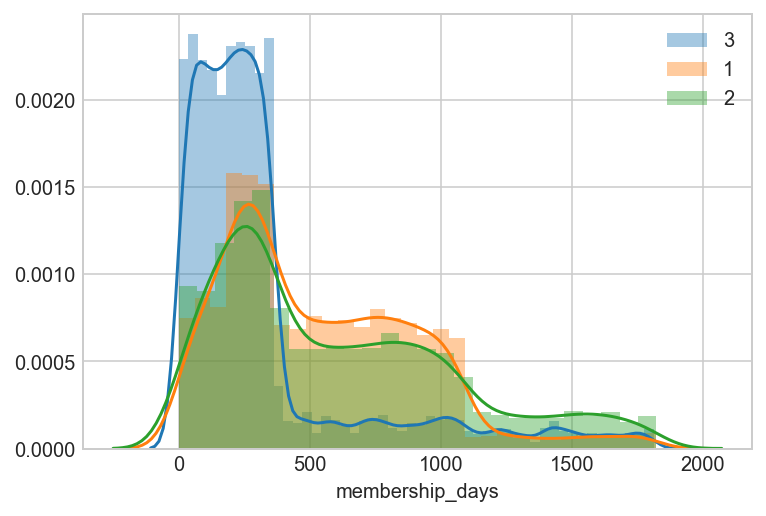

In [111]:
compare_cluster_distributions('membership_days')

### Analyze response ratios by cluster
**cluster3**
- If we focus on cluster 3 for now, we know from above that cluster 3 is the group that has low income, low spending, and low membership days
- Cluster 3 had no responses throughout the dataset, expect some invalid responses
- Meanwhile, both cluster 1 and 2 have higher invalid responses in all offer types
- Which suggests that, cluster 3 are customers who are the more junior customers with lower income, younger age, lower membership period, who might not be too familiar with the app and don't view offers but still complete some offers.

**cluster 1**
- In general, cluster1 has higher response rate than cluster 2
- From the above graphs, we know that cluster 1 has the highest income, highest average spendings, highest in age, and the longest memberships
- Furthermore, according to prior EDA, cluster 1 is the group of demographic with the highest invalid response rate, which indicates that they are senior people with high income, long membership length, and have a consistent purchasing habit without the influence of offers.

In [112]:
def compare_cluster_ratios(list_of_features):
    '''
    INPUT:
        list_of_features - At most 4 variables related to offer response from customers data (i.e., response, bogo_offers, discount_offers)
    OUTPUT:
        None - plot ratios of responses for given variables by cluster
    '''
    for i, feature in enumerate(list_of_features):
        plt.subplot(2,2,i+1)
        ratios = customers.groupby('cluster')[feature].mean().to_frame()
        sns.barplot(ratios.index, ratios[feature])
        plt.ylabel('')
        plt.title(feature)
        plt.tight_layout()

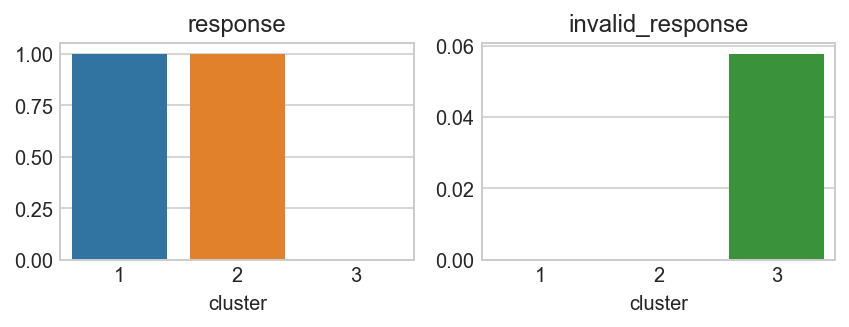

In [113]:
compare_cluster_ratios(['response','invalid_response'])

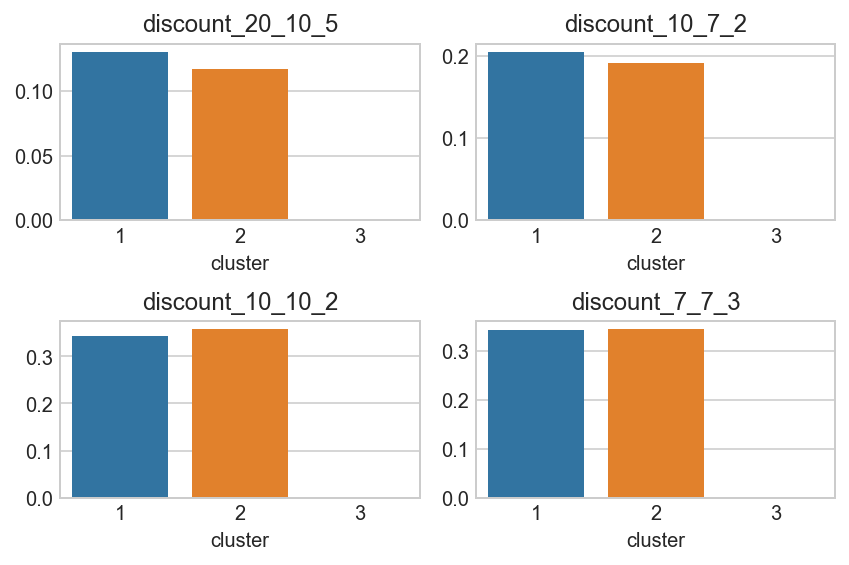

In [114]:
compare_cluster_ratios(discount_offers)

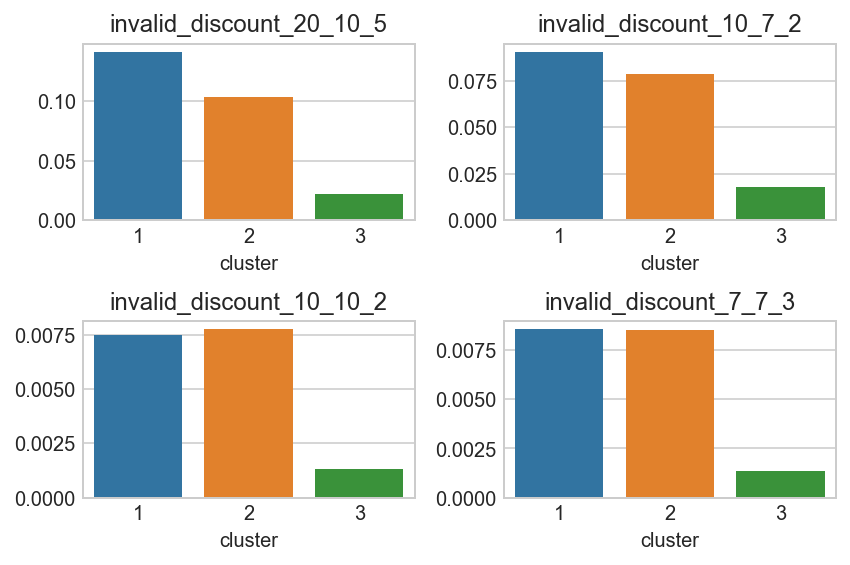

In [115]:
compare_cluster_ratios(['invalid_'+i for i in discount_offers])

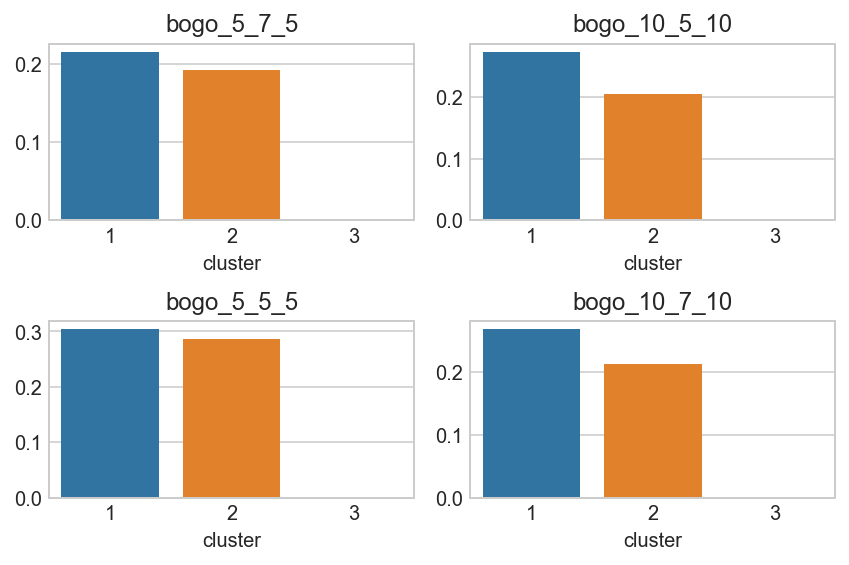

In [116]:
compare_cluster_ratios(bogo_offers)

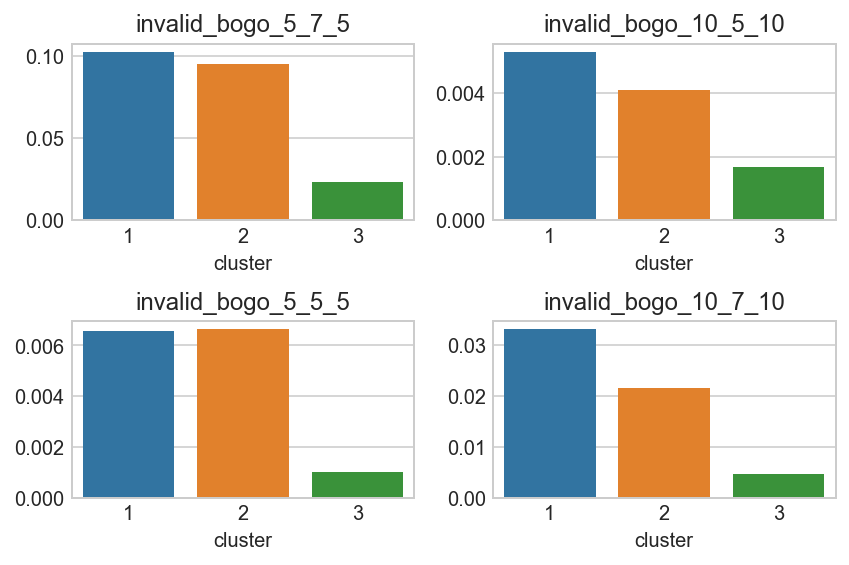

In [117]:
compare_cluster_ratios(['invalid_'+i for i in bogo_offers])

# Build Machine Learning Model to classify customer response to offers
- By predicting whether a customer will respond to an offer, we can build focused marketing campaigns to maximize returns

### The reason why this ratio is different is because customer_funnels has removed some customers with only informational offer events

In [37]:
# Examine the ratios of target classes to decide on the classification metrics
print('valid response ratios:')
print(customers.response.value_counts() / len(customers))
print('\n')
print('invalid response ratios:')
print(customers.invalid_response.value_counts() / len(customers))

valid response ratios:
1    0.797031
0    0.202969
Name: response, dtype: float64


invalid response ratios:
0    0.988259
1    0.011741
Name: invalid_response, dtype: float64


In [38]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days','avg_weekly_transactions','avg_weekly_amount_spent']]
# y = customers['response']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)
X.head()

,age,income,membership_days,avg_weekly_transactions,avg_weekly_amount_spent,gender_F,gender_M,gender_O
0,55.0,112000.0,376,1.500000,25.057500,1,0,0
1,75.0,100000.0,443,1.750000,22.900000,1,0,0
2,68.0,70000.0,91,1.500000,19.037500,0,1,0
3,65.0,53000.0,167,1.000000,12.143333,0,1,0
4,58.0,51000.0,257,1.333333,3.135000,0,1,0


## Compare ROC curves for different target variables
A target variable can be the response column, which is the general offer response. Or it can be response for a specific offer type

In [39]:
def compare_roc(target):
    '''
    plot ROC for the given target variable - response/invalid response
    '''
    y = customers[target]
    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'ROC for {target}')

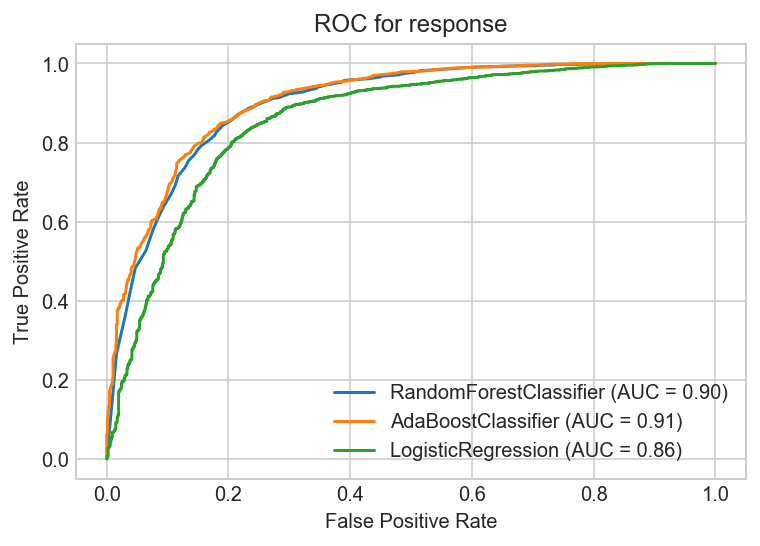

In [40]:
compare_roc('response')

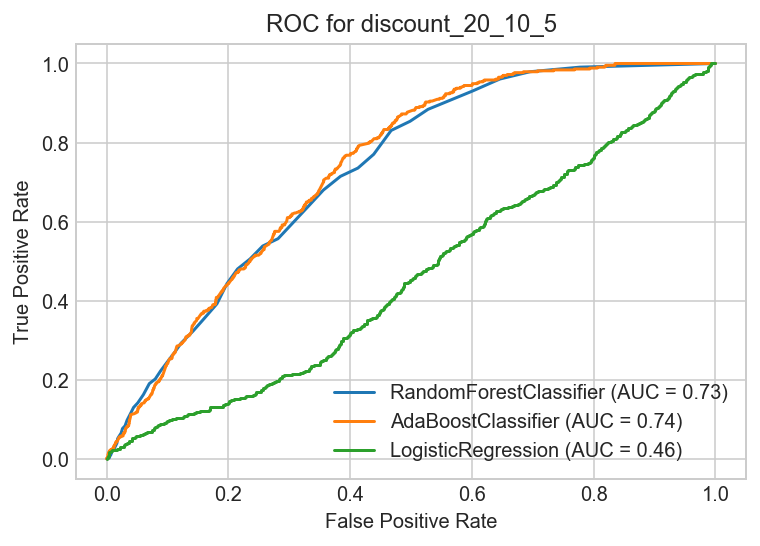

In [41]:
compare_roc('discount_20_10_5')

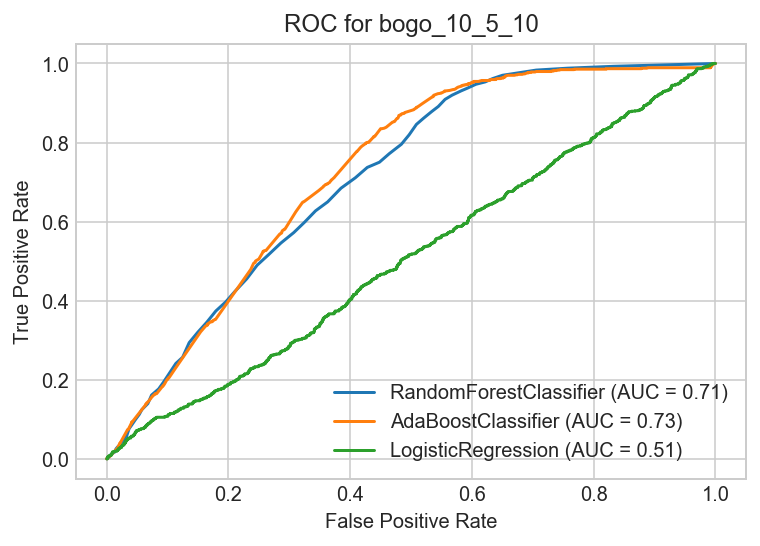

In [42]:
compare_roc('bogo_10_5_10')

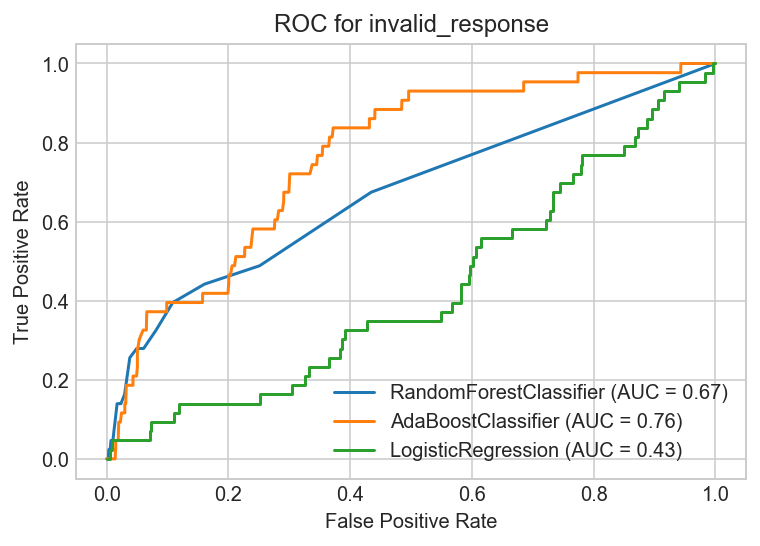

In [43]:
compare_roc('invalid_response')

# Use GridSearchCV to find the best parameters for AdaBoost

In [44]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [45]:
# Set y as response
y = customers['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}
f1 score on the testset: 0.937524870672503
accuracy on the testset: 0.8940620782726046


# Conclusion
In this project, I conducted extensive EDA to compare demographic groups with regard to offer response behaviors; performed k-means clustering to cluster customers into 3 segments and examined each cluster's demographics and responses to each offer type; lastly, I built a AdaBoost Machine Learning Model to predict whether a customer will respond to an offer with a 0.91 ROC AUC, 0.93 f1 score and 0.89 accuracy. In terms of business impact, Starbucks is now capable of predict whether a customer will respond to an offer, as well as segments of customers with different responses to different offer types, so that they can target clusters of customers for sending out offers for promotion events.